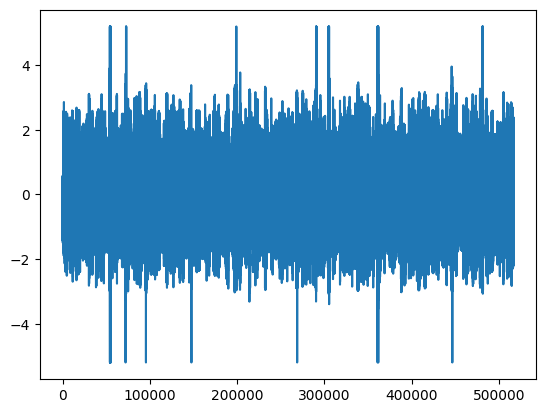

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('competition_package/datasets/train.csv')

timeseries = df[['0']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [35]:
seq_1 = df[df['seq_ix'] == 0]
seq_1_0 = seq_1[['0']].values.astype('float32')



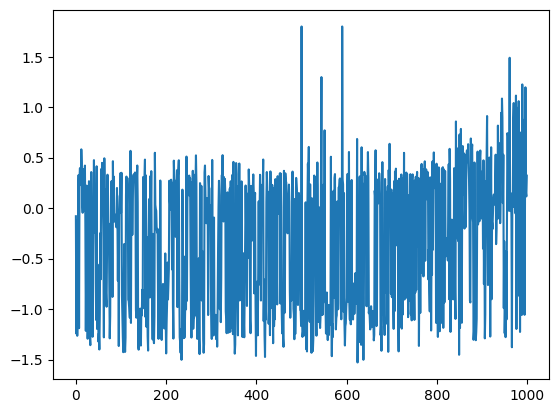

In [36]:
plt.plot(seq_1_0)
plt.show()

In [37]:
train_size = int(len(seq_1_0) * 0.80)
test_size = len(seq_1_0) - train_size
train, test = seq_1_0[:train_size], seq_1_0[train_size:]
print(len(train), len(test))

800 200


In [38]:
import torch
def create_dataset(dataset, lookback):
    """transform time series into prediction datset
    Args:
        dataset: a numpy array of time series, first dimenson is time steps
        lookback: size of window for prediction
    """

    X, y = [], []

    for i in range (len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([740, 60, 1]) torch.Size([740, 60, 1])
torch.Size([140, 60, 1]) torch.Size([140, 60, 1])


In [40]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50,1)
    def forward (self, x):
        x, _ = self.lstm(x)
        # extract last time step
        #x = x[:, -1, :]
        x = self.linear(x)
        return x

In [41]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = LSTMModel()
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print(f'Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}')


Epoch 1: train RMSE 0.6320, test RMSE 0.6911
Epoch 2: train RMSE 0.6301, test RMSE 0.7258
Epoch 3: train RMSE 0.6292, test RMSE 0.7340
Epoch 4: train RMSE 0.6283, test RMSE 0.7576
Epoch 5: train RMSE 0.6275, test RMSE 0.7243
Epoch 6: train RMSE 0.6268, test RMSE 0.7523
Epoch 7: train RMSE 0.6237, test RMSE 0.7249
Epoch 8: train RMSE 0.6206, test RMSE 0.7403
Epoch 9: train RMSE 0.6168, test RMSE 0.7632
Epoch 11: train RMSE 0.6028, test RMSE 0.7771
Epoch 12: train RMSE 0.5919, test RMSE 0.8191
Epoch 13: train RMSE 0.5754, test RMSE 0.8001
Epoch 14: train RMSE 0.5583, test RMSE 0.8490
Epoch 15: train RMSE 0.5452, test RMSE 0.8647
Epoch 16: train RMSE 0.5238, test RMSE 0.8482
Epoch 17: train RMSE 0.5109, test RMSE 0.8793
Epoch 18: train RMSE 0.4900, test RMSE 0.9166
Epoch 19: train RMSE 0.4757, test RMSE 0.9072
Epoch 21: train RMSE 0.4422, test RMSE 0.9242
Epoch 22: train RMSE 0.4423, test RMSE 0.9322
Epoch 23: train RMSE 0.4202, test RMSE 0.9330
Epoch 24: train RMSE 0.4046, test RMSE 0.92

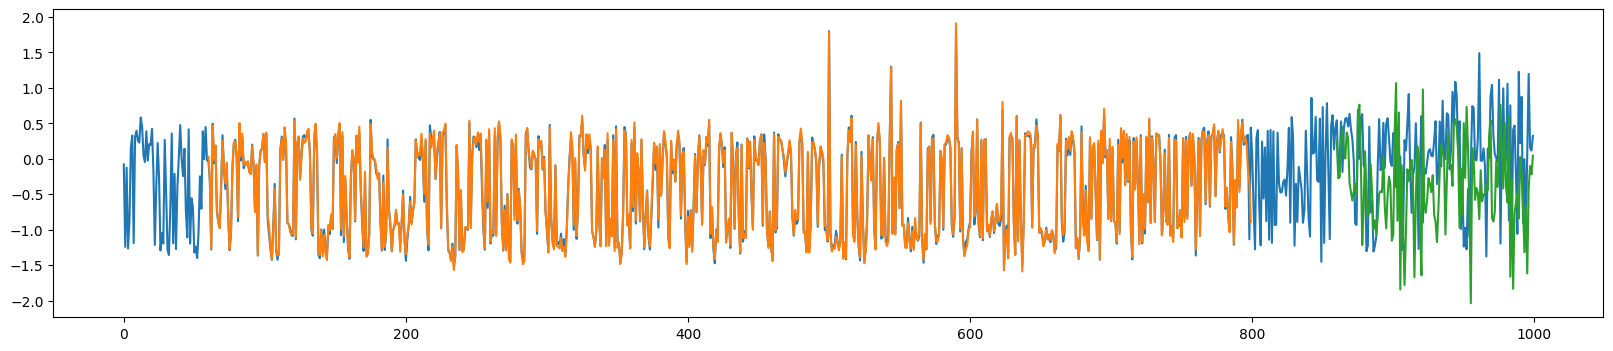

Train R²: 0.9862, Test R²: -1.3207


In [42]:
from sklearn.metrics import r2_score


with torch.no_grad():
    train_plot = np.ones_like(seq_1_0) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    #shift test predictions for plotting
    test_plot = np.ones_like(seq_1_0) * np.nan
    test_plot[train_size + lookback:len(seq_1_0)] = model(X_test)[:, -1, :]
    #train_r2 = r2_score(y_train.numpy(), y_pred)
    #test_r2 = r2_score(y_test.numpy(), y_pred)

#plot
plt.figure(figsize=(20, 4))
plt.plot(seq_1_0)
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()


with torch.no_grad():
    # Get predictions for train and test
    y_pred_train = model(X_train)[:, -1, :]  # Extract last timestep
    y_pred_test = model(X_test)[:, -1, :]    # Extract last timestep
    
    # Extract last timestep from targets to match predictions
    y_train_last = y_train[:, -1, :]  # Shape: [796, 1]
    y_test_last = y_test[:, -1, :]    # Shape: [196, 1]
    
    # Convert tensors to numpy arrays and flatten for r2_score
    y_train_np = y_train_last.cpu().numpy().flatten()
    y_test_np = y_test_last.cpu().numpy().flatten()
    y_pred_train_np = y_pred_train.cpu().numpy().flatten()
    y_pred_test_np = y_pred_test.cpu().numpy().flatten()
    
    # Calculate R² scores
    train_r2 = r2_score(y_train_np, y_pred_train_np)
    test_r2 = r2_score(y_test_np, y_pred_test_np)
    
    print(f'Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


#print(f'Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')




In [43]:
# Install Optuna if needed (run once)
# !pip install optuna

import optuna
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 128, step=16)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    batch_size = trial.suggest_int('batch_size', 4, 32, step=4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 50, 200, step=25)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    
    # Create model with suggested hyperparameters
    class LSTMModel(nn.Module):
        def __init__(self, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=1, 
                hidden_size=hidden_size, 
                num_layers=num_layers, 
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0
            )
            self.linear = nn.Linear(hidden_size, 1)
            
        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x
    
    model = LSTMModel(hidden_size, num_layers, dropout)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(
        data.TensorDataset(X_train, y_train), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)[:, -1, :]
        y_test_last = y_test[:, -1, :]
        
        y_test_np = y_test_last.cpu().numpy().flatten()
        y_pred_test_np = y_pred_test.cpu().numpy().flatten()
        
        test_r2 = r2_score(y_test_np, y_pred_test_np)
    
    return test_r2  # Optuna will maximize this

# Create study and optimize
study = optuna.create_study(
    direction='maximize',  # We want to maximize R²
    study_name='lstm_hyperparameter_tuning'
)

# Run optimization (start with fewer trials to test, then increase)
print("Starting hyperparameter optimization...")
study.optimize(objective, n_trials=30)

# Print best results
print(f"\n{'='*50}")
print(f"Best trial:")
print(f"  Test R²: {study.best_value:.4f}")
print(f"  Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
print(f"{'='*50}")

/Users/simon_pl19nc8/Desktop/Code/Projects/wunderfund/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-13 18:54:00,430] A new study created in memory with name: lstm_hyperparameter_tuning


Starting hyperparameter optimization...


[I 2025-11-13 18:55:07,641] Trial 0 finished with value: -0.831034779548645 and parameters: {'hidden_size': 112, 'num_layers': 1, 'batch_size': 12, 'learning_rate': 0.0011430393040666364, 'n_epochs': 150, 'dropout': 0.15388041961042137}. Best is trial 0 with value: -0.831034779548645.
[I 2025-11-13 18:57:08,020] Trial 1 finished with value: -0.6082149744033813 and parameters: {'hidden_size': 80, 'num_layers': 3, 'batch_size': 28, 'learning_rate': 0.0044940607205049415, 'n_epochs': 150, 'dropout': 0.13881740305323387}. Best is trial 1 with value: -0.6082149744033813.
[I 2025-11-13 18:57:16,953] Trial 2 finished with value: -0.7143137454986572 and parameters: {'hidden_size': 16, 'num_layers': 1, 'batch_size': 24, 'learning_rate': 0.0007908568965225889, 'n_epochs': 75, 'dropout': 0.25744089102798495}. Best is trial 1 with value: -0.6082149744033813.
[I 2025-11-13 18:57:26,643] Trial 3 finished with value: -0.648574948310852 and parameters: {'hidden_size': 16, 'num_layers': 2, 'batch_size'


Best trial:
  Test R²: -0.2988
  Best hyperparameters:
    hidden_size: 128
    num_layers: 3
    batch_size: 16
    learning_rate: 0.009675875124738253
    n_epochs: 100
    dropout: 0.002221008191730753


In [45]:
# Visualize optimization results
import optuna.visualization as vis

# Plot optimization history (shows how R² improved over trials)
vis.plot_optimization_history(study).show()

# Plot parameter importances (shows which hyperparameters matter most)
vis.plot_param_importances(study).show()


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [44]:
# Train final model with best hyperparameters
best_params = study.best_params

class LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

final_model = LSTMModel(
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), 
    batch_size=best_params['batch_size'], 
    shuffle=True
)

print(f"Training final model with best hyperparameters for {best_params['n_epochs']} epochs...")
for epoch in range(best_params['n_epochs']):
    final_model.train()
    for X_batch, y_batch in loader:
        y_pred = final_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch + 1}/{best_params['n_epochs']}")

# Evaluate final model
final_model.eval()
with torch.no_grad():
    y_pred_train = final_model(X_train)[:, -1, :]
    y_pred_test = final_model(X_test)[:, -1, :]
    y_train_last = y_train[:, -1, :]
    y_test_last = y_test[:, -1, :]
    
    train_r2 = r2_score(
        y_train_last.cpu().numpy().flatten(),
        y_pred_train.cpu().numpy().flatten()
    )
    test_r2 = r2_score(
        y_test_last.cpu().numpy().flatten(),
        y_pred_test.cpu().numpy().flatten()
    )
    
    print(f"\nFinal Model Results:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")

Training final model with best hyperparameters for 100 epochs...
Epoch 25/100
Epoch 50/100
Epoch 75/100
Epoch 100/100

Final Model Results:
  Train R²: 0.9649
  Test R²: -0.4629
